In [1]:
# install dependencies
#! pip install fastdtw

In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
import os

In [3]:
# fonction pour importer un audio
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

# utilisation
signal, sr = load_audio("test3/agauche.wav")
print(f"Signal shape: {signal.shape}, Sample rate: {sr}")

Signal shape: (11154,), Sample rate: 16000


In [4]:
# Fonction pour calculer les MFCC 
def extract_mfcc(signal, sample_rate, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc, hop_length=512, n_fft=2048)
    return mfcc.T

# utilisation
mfcc = extract_mfcc(signal, sr)
print(f"MFCC shape: {mfcc.shape}")

MFCC shape: (22, 13)


In [5]:
# Fonction pour calculer la distance entre un fichier de test et un fichier de référence 
def calculate_dtw_distance(mfcc1, mfcc2):
    distance, _ = fastdtw(mfcc1, mfcc2, dist=lambda x, y: np.linalg.norm(x - y))
    return distance

# utilisation
ref_signal, ref_sr = load_audio("test3/agauche2.wav")
ref_mfcc = extract_mfcc(ref_signal, ref_sr)
distance = calculate_dtw_distance(mfcc, ref_mfcc)
print(f"DTW Distance: {distance}")


DTW Distance: 2205.3554567172037


In [6]:
# Fonction principale pour la reconnaissance 
def recognize_command(test_file, reference_files):
    # Charger et extraire les MFCC du fichier de test
    test_signal, test_sr = load_audio(test_file)
    test_mfcc = extract_mfcc(test_signal, test_sr)
    
    # Initialiser les distances
    distances = {}
    
    # Comparer avec chaque fichier de référence
    for ref_file in reference_files:
        ref_signal, ref_sr = load_audio(ref_file)
        ref_mfcc = extract_mfcc(ref_signal, ref_sr)
        distance = calculate_dtw_distance(test_mfcc, ref_mfcc)
        distances[ref_file] = distance
    
    # Trouver la commande avec la plus petite distance
    recognized_command = min(distances, key=distances.get)
    return recognized_command, distances

In [7]:
reference_files = ['test3/'+i for i in ["agauche2.wav", "adroite2.wav", "enavant2.wav", "stop2.wav"]]

test_file = "test3/agauche.wav"

recognized_command, distances = recognize_command(test_file, reference_files)
print(f"Recognized Command: {recognized_command}")
for i in distances:
    print(f"Distance to references: {i[6:-4]} is {distances[i]}")


Recognized Command: test3/agauche2.wav
Distance to references: agauche2 is 2205.3554567172037
Distance to references: adroite2 is 3375.1068892659446
Distance to references: enavant2 is 2624.5582627064973
Distance to references: stop2 is 3463.075128689807


We can see that that gauche2 is indeed the good answer here. Because it has the smallest distance to the refrence.

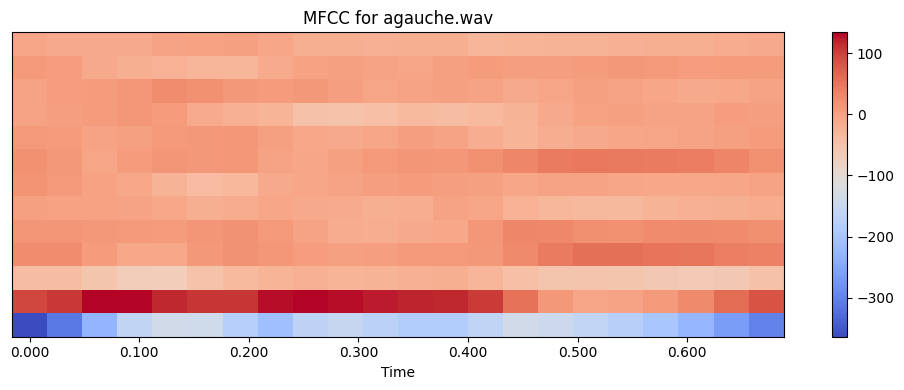

In [8]:
def plot_mfcc(signal, sample_rate, title="MFCC"):
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, hop_length=512, n_fft=2048)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis="time", sr=sample_rate, hop_length=512)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

#Utilisation 
plot_mfcc(signal, sr, title="MFCC for agauche.wav")

Observations générales :

- Axes :

L'axe des abscisses (x) représente le temps en secondes.

L'axe des ordonnées (y) représente les différents coefficients MFCC (généralement 13 ou plus selon les paramètres).

- Intensité des couleurs :

Les couleurs varient du bleu (valeurs basses) au rouge (valeurs élevées).

Cela indique les variations d'énergie pour chaque coefficient MFCC sur la durée du signal.

- Segments temporels :

On observe des zones où les valeurs des MFCC changent de manière significative, ce qui reflète les transitions dans les caractéristiques spectrales du signal audio. Ces transitions pourraient correspondre à des phonèmes ou à des parties spécifiques de la commande vocale.

- Concentration d'énergie :

Une bande rouge claire est visible dans les coefficients inférieurs (proche de 0). Cela indique que l'énergie principale est concentrée dans les premiers coefficients MFCC. C'est typique, car les premiers coefficients capturent l'énergie spectrale globale.

Les coefficients plus élevés (en haut de l'axe y) sont moins significatifs, car ils capturent des détails plus fins du spectre.

- Transitions temporelles :

Les changements dans les couleurs sur l'axe du temps montrent des variations dans les caractéristiques du son, probablement dues à des variations de tonalité ou de contenu phonétique dans la commande "À gauche".

- Durée du signal :
La commande semble relativement courte, avec une durée d'environ 0,6 seconde. Cela correspond bien à une commande vocale simple.

# Précision de la classification

In [9]:
import os
import librosa
import numpy as np
from fastdtw import fastdtw

audio_folder = "test3"

commands = ["adroite", "agauche", "enavant", "stop"]

# Fonction pour charger un fichier audio 
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

# Fonction pour extraire les MFCC
def extract_mfcc(signal, sample_rate, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc, hop_length=512, n_fft=2048)
    return mfcc.T

# Fonction pour calculer la distance DTW
def calculate_dtw_distance(mfcc1, mfcc2):
    distance, _ = fastdtw(mfcc1, mfcc2, dist=lambda x, y: np.linalg.norm(x - y))
    return distance

# Reconnaissance des commandes
def classify_commands(audio_folder, commands):
    reference_files = {}
    test_files = []
    results = []

    # Ici on prend 2 comme ref
    for command in commands:
        ref_file = [f for f in os.listdir(audio_folder) if f.startswith(f"{command}2") and (f.endswith(".wav") or f.endswith(".mp3"))]
        if ref_file:
            reference_files[command] = os.path.join(audio_folder, ref_file[0])
        test_files += [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) 
                       if f.startswith(command) and f != ref_file[0] and (f.endswith(".wav") or f.endswith(".mp3"))]

    # Classification
    for test_file in test_files:
        test_signal, test_sr = load_audio(test_file)
        test_mfcc = extract_mfcc(test_signal, test_sr)

        distances = {}
        for command, ref_file in reference_files.items():
            ref_signal, ref_sr = load_audio(ref_file)
            ref_mfcc = extract_mfcc(ref_signal, ref_sr)
            distances[command] = calculate_dtw_distance(test_mfcc, ref_mfcc)

        # commande avec la distance minimale
        predicted_command = min(distances, key=distances.get)
        actual_command = os.path.basename(test_file).split(".")[0].split("3")[0].split("4")[0].split("5")[0]  # Extraire la commande réelle
        results.append((test_file, actual_command, predicted_command))

    return results

# Calculer la précision
def calculate_accuracy(results):
    correct = sum(1 for _, actual, predicted in results if actual == predicted)
    total = len(results)
    accuracy = correct / total if total > 0 else 0
    return accuracy

results = classify_commands(audio_folder, commands)
accuracy = calculate_accuracy(results)

# Affichage
print("Résultats de classification :")
for test_file, actual, predicted in results:
    print(f"Fichier : {test_file} | Commande réelle : {actual} | Commande prédite : {predicted}")

print(f"\nPrécision de classification : {accuracy * 100:.2f}%")


Résultats de classification :
Fichier : test3/adroite.wav | Commande réelle : adroite | Commande prédite : adroite
Fichier : test3/adroite4.mp3 | Commande réelle : adroite | Commande prédite : adroite
Fichier : test3/adroite5.mp3 | Commande réelle : adroite | Commande prédite : enavant
Fichier : test3/adroite3.wav | Commande réelle : adroite | Commande prédite : enavant
Fichier : test3/agauche4.mp3 | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/agauche5.mp3 | Commande réelle : agauche | Commande prédite : adroite
Fichier : test3/agauche.wav | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/agauche3.wav | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/enavant3.wav | Commande réelle : enavant | Commande prédite : enavant
Fichier : test3/enavant.wav | Commande réelle : enavant | Commande prédite : enavant
Fichier : test3/enavant4.mp3 | Commande réelle : enavant | Commande prédite : enavant
Fichier : test3/enavant5.mp

In [10]:
import os
import librosa
import numpy as np
from fastdtw import fastdtw

audio_folder = "test3"

commands = ["adroite", "agauche", "enavant", "stop"]

# ici on va normaliser le signal 
def normalize_signal(signal):
    return signal / np.max(np.abs(signal))

# Réduction de bruit
def reduce_noise(signal, sr):
    return librosa.effects.remix(signal, intervals=librosa.effects.split(signal, top_db=20))


# Charger et prétraiter l'audio
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    signal = normalize_signal(signal)
    signal = reduce_noise(signal, sample_rate)
    return signal, sample_rate

# Extraction améliorée des MFCC avec ∆ et ∆²
def extract_mfcc(signal, sample_rate, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc, hop_length=512, n_fft=2048)
    delta = librosa.feature.delta(mfcc, width=3)  # Réduire la largeur de la fenêtre
    delta2 = librosa.feature.delta(mfcc, order=2, width=3)
    return np.hstack([mfcc.T, delta.T, delta2.T])  # Concaténer MFCC, ∆, ∆²

# DTW
def calculate_dtw_distance(mfcc1, mfcc2):
    distance, _ = fastdtw(mfcc1, mfcc2, dist=lambda x, y: np.linalg.norm(x - y))
    return distance

# Classification
def classify_commands(audio_folder, commands):
    reference_files = {}
    test_files = []
    results = []

    # On prend 2 comme ref
    for command in commands:
        ref_file = [f for f in os.listdir(audio_folder) if f.startswith(f"{command}2") and (f.endswith(".wav") or f.endswith(".mp3"))]
        if ref_file:
            reference_files[command] = os.path.join(audio_folder, ref_file[0])
        test_files += [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) 
                       if f.startswith(command) and f != ref_file[0] and (f.endswith(".wav") or f.endswith(".mp3"))]

    # Classification
    for test_file in test_files:
        test_signal, test_sr = load_audio(test_file)
        test_mfcc = extract_mfcc(test_signal, test_sr)

        distances = {}
        for command, ref_file in reference_files.items():
            ref_signal, ref_sr = load_audio(ref_file)
            ref_mfcc = extract_mfcc(ref_signal, ref_sr)
            distances[command] = calculate_dtw_distance(test_mfcc, ref_mfcc)

        # commande avec la distance minimale
        predicted_command = min(distances, key=distances.get)
        actual_command = os.path.basename(test_file).split(".")[0].split("3")[0].split("4")[0].split("5")[0]  # Extraire la commande réelle
        results.append((test_file, actual_command, predicted_command))

    return results

# Calculer la précision
def calculate_accuracy(results):
    correct = sum(1 for _, actual, predicted in results if actual == predicted)
    total = len(results)
    accuracy = correct / total if total > 0 else 0
    return accuracy

results = classify_commands(audio_folder, commands)
accuracy = calculate_accuracy(results)

# Affichage 
print("Résultats de classification :")
for test_file, actual, predicted in results:
    print(f"Fichier : {test_file} | Commande réelle : {actual} | Commande prédite : {predicted}")

print(f"\nPrécision de classification : {accuracy * 100:.2f}%")


Résultats de classification :
Fichier : test3/adroite.wav | Commande réelle : adroite | Commande prédite : adroite
Fichier : test3/adroite4.mp3 | Commande réelle : adroite | Commande prédite : adroite
Fichier : test3/adroite5.mp3 | Commande réelle : adroite | Commande prédite : agauche
Fichier : test3/adroite3.wav | Commande réelle : adroite | Commande prédite : adroite
Fichier : test3/agauche4.mp3 | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/agauche5.mp3 | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/agauche.wav | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/agauche3.wav | Commande réelle : agauche | Commande prédite : agauche
Fichier : test3/enavant3.wav | Commande réelle : enavant | Commande prédite : adroite
Fichier : test3/enavant.wav | Commande réelle : enavant | Commande prédite : enavant
Fichier : test3/enavant4.mp3 | Commande réelle : enavant | Commande prédite : enavant
Fichier : test3/enavant5.mp